In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import random_split

import torcheval.metrics.functional as metrics

import pandas as pd 
import numpy as np
from tqdm import tqdm

torch.manual_seed(1000) # set the random seed

In [2]:

class SleepDataset(Dataset):
    def __init__(self, hr_file, ecg_file, window_size=30):
        self.df1 = pd.read_csv(hr_file)
        self.df2 = pd.read_csv(ecg_file)
        self.window_size = window_size

        self.freq1 = 1
        self.freq2 = 256

        
    def __len__(self):
        len1 = len(self.df1)/(self.freq1*self.window_size)
        len2 = len(self.df2)/(self.freq2*self.window_size)
        #should be the same but just in case 
        return round(min(len1,len2))

    def __getitem__(self, idx):
        start_window1 = self.window_size*idx*self.freq1
        start_window2 = self.window_size*idx*self.freq2
        # Extract heart rate data points and label for the current window
        hr = self.df1['heart_rate'].iloc[start_window1:start_window1+self.window_size*self.freq1].values
        labels = self.df1['psg_status'].iloc[start_window1]
        #optional: combine labels
        #labels = np.where(labels != 0, 1, labels)
        if labels in [2,3]:
            labels = 2
        elif labels in [4,5]:
            labels = 3

            

        ecg = self.df2['ECG'].iloc[start_window2:start_window2+self.window_size*self.freq2].values

        # Convert to PyTorch tensors
        hr = torch.tensor(hr, dtype=torch.float).unsqueeze(0)  # Add extra dimension at index 0
        labels = torch.tensor(labels, dtype=torch.long)
        ecg = torch.tensor(ecg, dtype=torch.float).unsqueeze(0)  # Add extra dimension at index 0



        return hr, ecg, labels

# Create an instance of the CustomDataset
dataset = SleepDataset(r'mesa_preproc/final/subject_0002.csv',r'mesa_preproc/final/subject_0002_ecg.csv')

# Create a PyTorch DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


    

In [4]:
# based on: https://github.com/akaraspt/tinysleepnet

class SleepNet_ECG(nn.Module):
    def __init__(self):
        super(SleepNet_ECG,self).__init__()
        self.pool1 = nn.MaxPool1d(8, 8) #kernel_size, stride
        self.pool2 = nn.MaxPool1d(4, 4) #kernel_size, stride

        self.conv1 = nn.Conv1d(1, 128, 8) #in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv1d(128, 128, 8) #in_channels, out_chanels, kernel_size

        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(128,128)
        

        self.fc1 = nn.Linear(29952, 32)
        self.fc2 = nn.Linear(32, 4)

        

    def forward(self, ecg):

        ecg = self.pool1(ecg)
        ecg = self.dropout(ecg)
        ecg = F.relu(self.conv1(ecg))
        ecg = F.relu(self.conv2(ecg))
        ecg = self.pool2(F.relu(self.conv2(ecg)))
        ecg = self.dropout(ecg)


        # Transpose dimensions for LSTM input
        ecg = ecg.permute(2, 0, 1)  # Shape: [seq_len, batch_size, input_size]
        
        ecg, _ = self.lstm(ecg)
        ecg = self.dropout(ecg)

        #Get size of final layer
        x_dim = ecg.size(0) * ecg.size(2)

        ecg = ecg.view(-1, x_dim)

        ecg = F.relu(self.fc1(ecg))
        ecg = self.fc2(ecg)
        ecg = ecg.squeeze(1) # Flatten to [batch_size]

        return ecg



In [5]:


dataset = SleepDataset(r'mesa_preproc/final/subject_0002.csv',r'mesa_preproc/final/subject_0002_ecg.csv')


# Define the sizes of train, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% of the data for training
val_size = int(0.15 * len(dataset))   # 15% of the data for validation
test_size = len(dataset) - train_size - val_size  # Remaining data for testing

# Use random_split to split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])






In [40]:


def train(model, train_data, val_data, batch_size=64,learning_rate = 0.01, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle = True)


    #calculate class weights (bc unblanced data)
    labels = []
    
    for batch in train_loader:
        _, _, label_batch = batch
        labels.append(label_batch)
    labels = torch.cat(labels, dim=0)

    class_counts = torch.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / (len(class_counts) * class_counts.float())
    class_weights /= class_weights.sum()


    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
        class_weights = class_weights.cuda()
    #############################################



    criterion = nn.CrossEntropyLoss(weight = class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, val_loss,train_loss, train_acc, val_acc, train_f1, val_f1 = [],[], [], [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        m = 0
        for hr,ecg, labels in tqdm(iter(train_loader)):



            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              hr = hr.cuda()
              ecg = ecg.cuda()
              labels = labels.cuda()
            #############################################


            out = model(ecg)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch


             # Compute statistics
            running_loss += loss.item() * hr.size(0)
            _, predicted = torch.max(out, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += hr.size(0)

            m += 1

        # Compute training epoch statistics
        train_loss = running_loss / total_samples
        train_accuracy = correct_predictions / total_samples
        iters.append(m)

        # Validate the model
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0
        val_f1 = 0.0
        n = 0
        with torch.no_grad():

            for val_hr_batch, val_ecg_batch, val_labels_batch in val_loader:
                #############################################
                #To Enable GPU Usage
                if use_cuda and torch.cuda.is_available():
                    val_hr_batch = val_hr_batch.cuda()
                    val_ecg_batch = val_ecg_batch.cuda()
                    val_labels_batch = val_labels_batch.cuda()
                #############################################
                val_outputs = model(val_ecg_batch)
                val_loss = criterion(val_outputs, val_labels_batch)

                val_running_loss += val_loss.item() * val_hr_batch.size(0)
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct_predictions += (val_predicted == val_labels_batch).sum().item()
                val_total_samples += val_hr_batch.size(0)
                val_f1 += metrics.multiclass_f1_score(val_predicted,val_labels_batch)
                n+=1
                #print(val_predicted)
                #print(val_labels_batch)

        # Compute validation statistics
        val_loss = val_running_loss / val_total_samples
        val_accuracy = val_correct_predictions / val_total_samples
        val_f1=val_f1/n
        
        # Save the current model (checkpoint) to a file
        #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        #model_path2 = get_model_name2(model.name, batch_size, learning_rate)

        #datadir = "/content/gdrive/MyDrive/Lab2_models/"
        #datadir = "data\models"

        #torch.save(model.state_dict(), (os.path.join(datadir,model_path)))
        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
            f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}')


        #np.savetxt("{}_train_acc.csv".format(os.path.join(datadir,model_path2)), train_acc)
        #np.savetxt("{}_val_acc.csv".format(os.path.join(datadir,model_path2)), val_acc)
        #np.savetxt("{}_losses.csv".format(os.path.join(datadir,model_path2)), losses)



    # plotting


    '''
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    '''






In [41]:
model = SleepNet_ECG()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print("Using CUDA")


train(model, train_dataset, val_dataset, batch_size=64,learning_rate = 0.001, num_epochs=20)


Using CUDA


100%|██████████| 12/12 [00:01<00:00,  7.62it/s]


Epoch [1/20], Train Loss: 1.4277, Train Accuracy: 0.2673, Val Loss: 1.3946, Val Accuracy: 0.4870, Val F1: 0.4515


100%|██████████| 12/12 [00:01<00:00,  8.73it/s]


Epoch [2/20], Train Loss: 1.3945, Train Accuracy: 0.4418, Val Loss: 1.4024, Val Accuracy: 0.2403, Val F1: 0.2232


100%|██████████| 12/12 [00:01<00:00,  8.71it/s]


Epoch [3/20], Train Loss: 1.3871, Train Accuracy: 0.4377, Val Loss: 1.3970, Val Accuracy: 0.4740, Val F1: 0.4792


100%|██████████| 12/12 [00:01<00:00,  8.51it/s]


Epoch [4/20], Train Loss: 1.3877, Train Accuracy: 0.3352, Val Loss: 1.3966, Val Accuracy: 0.2403, Val F1: 0.2536


100%|██████████| 12/12 [00:01<00:00,  8.64it/s]


Epoch [5/20], Train Loss: 1.3865, Train Accuracy: 0.3643, Val Loss: 1.3959, Val Accuracy: 0.4805, Val F1: 0.4768


100%|██████████| 12/12 [00:01<00:00,  8.34it/s]


Epoch [6/20], Train Loss: 1.3863, Train Accuracy: 0.5083, Val Loss: 1.3933, Val Accuracy: 0.4870, Val F1: 0.4972


100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Epoch [7/20], Train Loss: 1.3882, Train Accuracy: 0.5069, Val Loss: 1.3950, Val Accuracy: 0.4416, Val F1: 0.4531


100%|██████████| 12/12 [00:01<00:00,  8.67it/s]


Epoch [8/20], Train Loss: 1.3866, Train Accuracy: 0.2964, Val Loss: 1.4031, Val Accuracy: 0.2403, Val F1: 0.2536


100%|██████████| 12/12 [00:01<00:00,  8.71it/s]


Epoch [9/20], Train Loss: 1.3880, Train Accuracy: 0.2770, Val Loss: 1.4002, Val Accuracy: 0.2403, Val F1: 0.2460


100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch [10/20], Train Loss: 1.3860, Train Accuracy: 0.2978, Val Loss: 1.3968, Val Accuracy: 0.4740, Val F1: 0.4944


100%|██████████| 12/12 [00:01<00:00,  8.69it/s]


Epoch [11/20], Train Loss: 1.3855, Train Accuracy: 0.4335, Val Loss: 1.3978, Val Accuracy: 0.2403, Val F1: 0.2688


100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch [12/20], Train Loss: 1.3873, Train Accuracy: 0.3615, Val Loss: 1.4003, Val Accuracy: 0.2403, Val F1: 0.2308


100%|██████████| 12/12 [00:01<00:00,  8.62it/s]


Epoch [13/20], Train Loss: 1.3878, Train Accuracy: 0.4294, Val Loss: 1.3948, Val Accuracy: 0.5000, Val F1: 0.4848


100%|██████████| 12/12 [00:01<00:00,  8.42it/s]


Epoch [14/20], Train Loss: 1.3871, Train Accuracy: 0.4958, Val Loss: 1.3917, Val Accuracy: 0.4870, Val F1: 0.4820


100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Epoch [15/20], Train Loss: 1.3873, Train Accuracy: 0.4917, Val Loss: 1.3937, Val Accuracy: 0.4675, Val F1: 0.4435


100%|██████████| 12/12 [00:01<00:00,  8.64it/s]


Epoch [16/20], Train Loss: 1.3871, Train Accuracy: 0.3255, Val Loss: 1.3990, Val Accuracy: 0.2403, Val F1: 0.2232


100%|██████████| 12/12 [00:01<00:00,  8.58it/s]


Epoch [17/20], Train Loss: 1.3869, Train Accuracy: 0.2756, Val Loss: 1.3950, Val Accuracy: 0.2403, Val F1: 0.2536


100%|██████████| 12/12 [00:01<00:00,  8.62it/s]


Epoch [18/20], Train Loss: 1.3878, Train Accuracy: 0.4834, Val Loss: 1.3931, Val Accuracy: 0.4675, Val F1: 0.4435


100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch [19/20], Train Loss: 1.3862, Train Accuracy: 0.3587, Val Loss: 1.3967, Val Accuracy: 0.2403, Val F1: 0.2232


100%|██████████| 12/12 [00:01<00:00,  8.58it/s]


Epoch [20/20], Train Loss: 1.3879, Train Accuracy: 0.2770, Val Loss: 1.3988, Val Accuracy: 0.2403, Val F1: 0.2612


In [42]:
model = SleepNet_ECG()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print("Using CUDA")


train(model, train_dataset, val_dataset, batch_size=128,learning_rate = 0.0001, num_epochs=50)

Using CUDA


100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


Epoch [1/50], Train Loss: 1.3930, Train Accuracy: 0.1704, Val Loss: 1.3906, Val Accuracy: 0.2338, Val F1: 0.2479


100%|██████████| 6/6 [00:01<00:00,  4.31it/s]


Epoch [2/50], Train Loss: 1.3877, Train Accuracy: 0.2867, Val Loss: 1.3859, Val Accuracy: 0.4870, Val F1: 0.4615


100%|██████████| 6/6 [00:01<00:00,  4.37it/s]


Epoch [3/50], Train Loss: 1.3892, Train Accuracy: 0.4446, Val Loss: 1.3915, Val Accuracy: 0.4805, Val F1: 0.4883


100%|██████████| 6/6 [00:01<00:00,  4.33it/s]


Epoch [4/50], Train Loss: 1.3879, Train Accuracy: 0.4875, Val Loss: 1.3832, Val Accuracy: 0.4870, Val F1: 0.4309


100%|██████████| 6/6 [00:01<00:00,  3.43it/s]


Epoch [5/50], Train Loss: 1.3873, Train Accuracy: 0.4169, Val Loss: 1.3858, Val Accuracy: 0.4740, Val F1: 0.4231


100%|██████████| 6/6 [00:01<00:00,  4.28it/s]


Epoch [6/50], Train Loss: 1.3876, Train Accuracy: 0.4086, Val Loss: 1.3971, Val Accuracy: 0.2403, Val F1: 0.2212


100%|██████████| 6/6 [00:01<00:00,  4.32it/s]


Epoch [7/50], Train Loss: 1.3881, Train Accuracy: 0.2839, Val Loss: 1.3964, Val Accuracy: 0.2403, Val F1: 0.2058


100%|██████████| 6/6 [00:01<00:00,  4.16it/s]


Epoch [8/50], Train Loss: 1.3880, Train Accuracy: 0.3255, Val Loss: 1.3893, Val Accuracy: 0.4805, Val F1: 0.5496


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch [9/50], Train Loss: 1.3872, Train Accuracy: 0.3906, Val Loss: 1.3950, Val Accuracy: 0.4805, Val F1: 0.4883


100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


Epoch [10/50], Train Loss: 1.3867, Train Accuracy: 0.3809, Val Loss: 1.3904, Val Accuracy: 0.4156, Val F1: 0.4492


100%|██████████| 6/6 [00:01<00:00,  4.14it/s]


Epoch [11/50], Train Loss: 1.3869, Train Accuracy: 0.2729, Val Loss: 1.3859, Val Accuracy: 0.2208, Val F1: 0.2094


100%|██████████| 6/6 [00:01<00:00,  4.09it/s]


Epoch [12/50], Train Loss: 1.3867, Train Accuracy: 0.2756, Val Loss: 1.3853, Val Accuracy: 0.2403, Val F1: 0.2671


100%|██████████| 6/6 [00:01<00:00,  4.09it/s]


Epoch [13/50], Train Loss: 1.3874, Train Accuracy: 0.2867, Val Loss: 1.3891, Val Accuracy: 0.2532, Val F1: 0.2290


100%|██████████| 6/6 [00:01<00:00,  4.25it/s]


Epoch [14/50], Train Loss: 1.3862, Train Accuracy: 0.2936, Val Loss: 1.3898, Val Accuracy: 0.2468, Val F1: 0.2557


100%|██████████| 6/6 [00:01<00:00,  4.29it/s]


Epoch [15/50], Train Loss: 1.3858, Train Accuracy: 0.3075, Val Loss: 1.3929, Val Accuracy: 0.2922, Val F1: 0.2984


100%|██████████| 6/6 [00:01<00:00,  4.40it/s]


Epoch [16/50], Train Loss: 1.3882, Train Accuracy: 0.3463, Val Loss: 1.3911, Val Accuracy: 0.2338, Val F1: 0.2326


100%|██████████| 6/6 [00:01<00:00,  4.29it/s]


Epoch [17/50], Train Loss: 1.3867, Train Accuracy: 0.2465, Val Loss: 1.3863, Val Accuracy: 0.1883, Val F1: 0.1439


100%|██████████| 6/6 [00:01<00:00,  4.27it/s]


Epoch [18/50], Train Loss: 1.3878, Train Accuracy: 0.2299, Val Loss: 1.3921, Val Accuracy: 0.2403, Val F1: 0.2058


100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


Epoch [19/50], Train Loss: 1.3865, Train Accuracy: 0.2632, Val Loss: 1.3860, Val Accuracy: 0.2727, Val F1: 0.2407


100%|██████████| 6/6 [00:01<00:00,  4.32it/s]


Epoch [20/50], Train Loss: 1.3877, Train Accuracy: 0.1191, Val Loss: 1.3811, Val Accuracy: 0.1169, Val F1: 0.1929


100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


Epoch [21/50], Train Loss: 1.3858, Train Accuracy: 0.1302, Val Loss: 1.3867, Val Accuracy: 0.1883, Val F1: 0.2512


100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


Epoch [22/50], Train Loss: 1.3869, Train Accuracy: 0.2618, Val Loss: 1.3941, Val Accuracy: 0.2403, Val F1: 0.2058


100%|██████████| 6/6 [00:01<00:00,  4.36it/s]


Epoch [23/50], Train Loss: 1.3872, Train Accuracy: 0.2825, Val Loss: 1.3876, Val Accuracy: 0.2792, Val F1: 0.2599


100%|██████████| 6/6 [00:01<00:00,  4.35it/s]


Epoch [24/50], Train Loss: 1.3866, Train Accuracy: 0.2909, Val Loss: 1.3921, Val Accuracy: 0.2338, Val F1: 0.2326


100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


Epoch [25/50], Train Loss: 1.3877, Train Accuracy: 0.2812, Val Loss: 1.3961, Val Accuracy: 0.2857, Val F1: 0.3711


100%|██████████| 6/6 [00:01<00:00,  4.37it/s]


Epoch [26/50], Train Loss: 1.3875, Train Accuracy: 0.3546, Val Loss: 1.3949, Val Accuracy: 0.4870, Val F1: 0.4462


100%|██████████| 6/6 [00:01<00:00,  4.36it/s]


Epoch [27/50], Train Loss: 1.3856, Train Accuracy: 0.4709, Val Loss: 1.3917, Val Accuracy: 0.4740, Val F1: 0.4078


100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


Epoch [28/50], Train Loss: 1.3879, Train Accuracy: 0.3906, Val Loss: 1.3879, Val Accuracy: 0.3052, Val F1: 0.3215


100%|██████████| 6/6 [00:01<00:00,  4.35it/s]


Epoch [29/50], Train Loss: 1.3880, Train Accuracy: 0.3296, Val Loss: 1.3872, Val Accuracy: 0.3247, Val F1: 0.3332


100%|██████████| 6/6 [00:01<00:00,  4.26it/s]


Epoch [30/50], Train Loss: 1.3873, Train Accuracy: 0.3241, Val Loss: 1.3897, Val Accuracy: 0.2468, Val F1: 0.2710


100%|██████████| 6/6 [00:01<00:00,  4.35it/s]


Epoch [31/50], Train Loss: 1.3875, Train Accuracy: 0.3310, Val Loss: 1.3899, Val Accuracy: 0.2597, Val F1: 0.2175


100%|██████████| 6/6 [00:01<00:00,  4.34it/s]


Epoch [32/50], Train Loss: 1.3863, Train Accuracy: 0.2964, Val Loss: 1.3919, Val Accuracy: 0.3506, Val F1: 0.3335


100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


Epoch [33/50], Train Loss: 1.3870, Train Accuracy: 0.2867, Val Loss: 1.3922, Val Accuracy: 0.2338, Val F1: 0.2479


100%|██████████| 6/6 [00:01<00:00,  4.37it/s]


Epoch [34/50], Train Loss: 1.3868, Train Accuracy: 0.2424, Val Loss: 1.3898, Val Accuracy: 0.2143, Val F1: 0.2055


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


Epoch [35/50], Train Loss: 1.3874, Train Accuracy: 0.2133, Val Loss: 1.3881, Val Accuracy: 0.1948, Val F1: 0.1938


100%|██████████| 6/6 [00:01<00:00,  4.33it/s]


Epoch [36/50], Train Loss: 1.3868, Train Accuracy: 0.2382, Val Loss: 1.3933, Val Accuracy: 0.2403, Val F1: 0.2365


100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


Epoch [37/50], Train Loss: 1.3875, Train Accuracy: 0.2825, Val Loss: 1.3884, Val Accuracy: 0.2403, Val F1: 0.2825


100%|██████████| 6/6 [00:01<00:00,  4.35it/s]


Epoch [38/50], Train Loss: 1.3870, Train Accuracy: 0.2604, Val Loss: 1.3880, Val Accuracy: 0.2143, Val F1: 0.1902


100%|██████████| 6/6 [00:01<00:00,  4.33it/s]


Epoch [39/50], Train Loss: 1.3878, Train Accuracy: 0.2881, Val Loss: 1.3867, Val Accuracy: 0.4675, Val F1: 0.5111


100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


Epoch [40/50], Train Loss: 1.3857, Train Accuracy: 0.3878, Val Loss: 1.3897, Val Accuracy: 0.4675, Val F1: 0.4038


100%|██████████| 6/6 [00:01<00:00,  4.37it/s]


Epoch [41/50], Train Loss: 1.3867, Train Accuracy: 0.3476, Val Loss: 1.3945, Val Accuracy: 0.2662, Val F1: 0.2215


100%|██████████| 6/6 [00:01<00:00,  4.32it/s]


Epoch [42/50], Train Loss: 1.3871, Train Accuracy: 0.3421, Val Loss: 1.3930, Val Accuracy: 0.2987, Val F1: 0.3176


100%|██████████| 6/6 [00:01<00:00,  4.37it/s]


Epoch [43/50], Train Loss: 1.3867, Train Accuracy: 0.3407, Val Loss: 1.3896, Val Accuracy: 0.2857, Val F1: 0.2791


100%|██████████| 6/6 [00:01<00:00,  4.37it/s]


Epoch [44/50], Train Loss: 1.3847, Train Accuracy: 0.2604, Val Loss: 1.3936, Val Accuracy: 0.2208, Val F1: 0.2094


100%|██████████| 6/6 [00:01<00:00,  4.41it/s]


Epoch [45/50], Train Loss: 1.3893, Train Accuracy: 0.2701, Val Loss: 1.3997, Val Accuracy: 0.2403, Val F1: 0.2825


100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


Epoch [46/50], Train Loss: 1.3853, Train Accuracy: 0.2784, Val Loss: 1.3931, Val Accuracy: 0.2662, Val F1: 0.2521


100%|██████████| 6/6 [00:01<00:00,  4.37it/s]


Epoch [47/50], Train Loss: 1.3874, Train Accuracy: 0.3130, Val Loss: 1.3925, Val Accuracy: 0.4416, Val F1: 0.4035


100%|██████████| 6/6 [00:01<00:00,  4.32it/s]


Epoch [48/50], Train Loss: 1.3876, Train Accuracy: 0.3601, Val Loss: 1.3790, Val Accuracy: 0.1429, Val F1: 0.1013


100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


Epoch [49/50], Train Loss: 1.3863, Train Accuracy: 0.3767, Val Loss: 1.3886, Val Accuracy: 0.4870, Val F1: 0.5382


100%|██████████| 6/6 [00:01<00:00,  4.32it/s]


Epoch [50/50], Train Loss: 1.3864, Train Accuracy: 0.4266, Val Loss: 1.3906, Val Accuracy: 0.4740, Val F1: 0.5303


Using CUDA
Epoch  0


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Training Accuracy:  0.1786703601108033
Training Loss:  0.022355636581778526
Validation Accuracy:  0.14935064935064934
Epoch  1


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Training Accuracy:  0.1772853185595568
Training Loss:  0.021289296448230743
Validation Accuracy:  0.13636363636363635
Epoch  2


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Training Accuracy:  0.1772853185595568
Training Loss:  0.021832585334777832
Validation Accuracy:  0.13636363636363635
Epoch  3


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Training Accuracy:  0.1772853185595568
Training Loss:  0.021545641124248505
Validation Accuracy:  0.13636363636363635
Epoch  4


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.1772853185595568
Training Loss:  0.021859358996152878
Validation Accuracy:  0.13636363636363635
Epoch  5


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.18005540166204986
Training Loss:  0.021273048594594002
Validation Accuracy:  0.14285714285714285
Epoch  6


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Training Accuracy:  0.26454293628808867
Training Loss:  0.02204952947795391
Validation Accuracy:  0.3116883116883117
Epoch  7


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.1772853185595568
Training Loss:  0.021523796021938324
Validation Accuracy:  0.14285714285714285
Epoch  8


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Training Accuracy:  0.1772853185595568
Training Loss:  0.021897442638874054
Validation Accuracy:  0.13636363636363635
Epoch  9


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Training Accuracy:  0.1772853185595568
Training Loss:  0.022068725898861885
Validation Accuracy:  0.13636363636363635
Epoch  10


100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


Training Accuracy:  0.1772853185595568
Training Loss:  0.021343529224395752
Validation Accuracy:  0.13636363636363635
Epoch  11


100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


Training Accuracy:  0.2451523545706371
Training Loss:  0.021641267463564873
Validation Accuracy:  0.2857142857142857
Epoch  12


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Training Accuracy:  0.1814404432132964
Training Loss:  0.021511970087885857
Validation Accuracy:  0.14285714285714285
Epoch  13


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Training Accuracy:  0.22022160664819945
Training Loss:  0.021720927208662033
Validation Accuracy:  0.19480519480519481
Epoch  14


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.23407202216066483
Training Loss:  0.022119026631116867
Validation Accuracy:  0.24675324675324675
Epoch  15


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.18005540166204986
Training Loss:  0.02149350754916668
Validation Accuracy:  0.13636363636363635
Epoch  16


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Training Accuracy:  0.24653739612188366
Training Loss:  0.021672766655683517
Validation Accuracy:  0.2727272727272727
Epoch  17


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Training Accuracy:  0.27008310249307477
Training Loss:  0.021855803206562996
Validation Accuracy:  0.2922077922077922
Epoch  18


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Training Accuracy:  0.17590027700831026
Training Loss:  0.021689241752028465
Validation Accuracy:  0.13636363636363635
Epoch  19


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Training Accuracy:  0.19113573407202217
Training Loss:  0.021468982100486755
Validation Accuracy:  0.14285714285714285
Epoch  20


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.26869806094182824
Training Loss:  0.021286074072122574
Validation Accuracy:  0.3181818181818182
Epoch  21


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.27008310249307477
Training Loss:  0.02164243906736374
Validation Accuracy:  0.2922077922077922
Epoch  22


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.22853185595567868
Training Loss:  0.02138541266322136
Validation Accuracy:  0.2012987012987013
Epoch  23


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.21052631578947367
Training Loss:  0.021824149414896965
Validation Accuracy:  0.18831168831168832
Epoch  24


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.20221606648199447
Training Loss:  0.02166529931128025
Validation Accuracy:  0.18831168831168832
Epoch  25


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Training Accuracy:  0.2562326869806094
Training Loss:  0.022336212918162346
Validation Accuracy:  0.2727272727272727
Epoch  26


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Training Accuracy:  0.4515235457063712
Training Loss:  0.021787621080875397
Validation Accuracy:  0.36363636363636365
Epoch  27


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.5041551246537396
Training Loss:  0.021509261801838875
Validation Accuracy:  0.5064935064935064
Epoch  28


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.2659279778393352
Training Loss:  0.021181561052799225
Validation Accuracy:  0.3116883116883117
Epoch  29


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Training Accuracy:  0.27008310249307477
Training Loss:  0.021693533286452293
Validation Accuracy:  0.3181818181818182
Epoch  30


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.4916897506925208
Training Loss:  0.021726958453655243
Validation Accuracy:  0.474025974025974
Epoch  31


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.3975069252077562
Training Loss:  0.022033831104636192
Validation Accuracy:  0.45454545454545453
Epoch  32


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.5083102493074793
Training Loss:  0.02146400511264801
Validation Accuracy:  0.5064935064935064
Epoch  33


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Training Accuracy:  0.5110803324099723
Training Loss:  0.021439045667648315
Validation Accuracy:  0.4935064935064935
Epoch  34


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Training Accuracy:  0.2659279778393352
Training Loss:  0.02175188809633255
Validation Accuracy:  0.3116883116883117
Epoch  35


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.2659279778393352
Training Loss:  0.022176088765263557
Validation Accuracy:  0.3116883116883117
Epoch  36


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Training Accuracy:  0.5083102493074793
Training Loss:  0.021690089255571365
Validation Accuracy:  0.5064935064935064
Epoch  37


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.5083102493074793
Training Loss:  0.02166619710624218
Validation Accuracy:  0.5064935064935064
Epoch  38


100%|██████████| 12/12 [00:22<00:00,  1.89s/it]


Training Accuracy:  0.28254847645429365
Training Loss:  0.02199830487370491
Validation Accuracy:  0.3246753246753247
Epoch  39


100%|██████████| 12/12 [00:35<00:00,  2.93s/it]


Training Accuracy:  0.5041551246537396
Training Loss:  0.021444855257868767
Validation Accuracy:  0.5064935064935064
Epoch  40


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Training Accuracy:  0.48476454293628807
Training Loss:  0.021679433062672615
Validation Accuracy:  0.538961038961039
Epoch  41


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Training Accuracy:  0.4889196675900277
Training Loss:  0.021392138674855232
Validation Accuracy:  0.487012987012987
Epoch  42


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Training Accuracy:  0.26454293628808867
Training Loss:  0.02175305038690567
Validation Accuracy:  0.3246753246753247
Epoch  43


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Training Accuracy:  0.4986149584487535
Training Loss:  0.021295735612511635
Validation Accuracy:  0.5324675324675324
Epoch  44


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Training Accuracy:  0.5083102493074793
Training Loss:  0.02199374884366989
Validation Accuracy:  0.5064935064935064
Epoch  45


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Training Accuracy:  0.5083102493074793
Training Loss:  0.021656490862369537
Validation Accuracy:  0.487012987012987
Epoch  46


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Training Accuracy:  0.4889196675900277
Training Loss:  0.021781545132398605
Validation Accuracy:  0.4935064935064935
Epoch  47


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Training Accuracy:  0.27008310249307477
Training Loss:  0.02200951986014843
Validation Accuracy:  0.3181818181818182
Epoch  48


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Training Accuracy:  0.49584487534626037
Training Loss:  0.02143275737762451
Validation Accuracy:  0.5194805194805194
Epoch  49


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Training Accuracy:  0.4903047091412742
Training Loss:  0.02178451605141163
Validation Accuracy:  0.512987012987013
Epoch  50


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Training Accuracy:  0.4889196675900277
Training Loss:  0.021682562306523323
Validation Accuracy:  0.45454545454545453
Epoch  51


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Training Accuracy:  0.3407202216066482
Training Loss:  0.021689841523766518
Validation Accuracy:  0.34415584415584416
Epoch  52


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Training Accuracy:  0.4390581717451524
Training Loss:  0.02188662439584732
Validation Accuracy:  0.5194805194805194
Epoch  53


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Training Accuracy:  0.502770083102493
Training Loss:  0.02137121744453907
Validation Accuracy:  0.5
Epoch  54


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Training Accuracy:  0.4099722991689751
Training Loss:  0.021902622655034065
Validation Accuracy:  0.4025974025974026
Epoch  55


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Training Accuracy:  0.47229916897506924
Training Loss:  0.02201320044696331
Validation Accuracy:  0.461038961038961
Epoch  56


100%|██████████| 12/12 [00:08<00:00,  1.33it/s]


Training Accuracy:  0.4889196675900277
Training Loss:  0.02167643792927265
Validation Accuracy:  0.42857142857142855
Epoch  57


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Training Accuracy:  0.47229916897506924
Training Loss:  0.02165028639137745
Validation Accuracy:  0.5064935064935064
Epoch  58


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Training Accuracy:  0.2894736842105263
Training Loss:  0.021642083302140236
Validation Accuracy:  0.33766233766233766
Epoch  59


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Training Accuracy:  0.26177285318559557
Training Loss:  0.02142271399497986
Validation Accuracy:  0.3181818181818182
Epoch  60


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Training Accuracy:  0.2659279778393352
Training Loss:  0.021802611649036407
Validation Accuracy:  0.3181818181818182
Epoch  61


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Training Accuracy:  0.4155124653739612
Training Loss:  0.021679900586605072
Validation Accuracy:  0.4025974025974026
Epoch  62


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Training Accuracy:  0.5083102493074793
Training Loss:  0.021830275654792786
Validation Accuracy:  0.5
Epoch  63


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Training Accuracy:  0.2299168975069252
Training Loss:  0.02185174450278282
Validation Accuracy:  0.18831168831168832
Epoch  64


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Training Accuracy:  0.23268698060941828
Training Loss:  0.02156529575586319
Validation Accuracy:  0.22077922077922077
Epoch  65


100%|██████████| 12/12 [00:08<00:00,  1.33it/s]


Training Accuracy:  0.49445983379501385
Training Loss:  0.0215012039989233
Validation Accuracy:  0.4935064935064935
Epoch  66


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.2659279778393352
Training Loss:  0.02172752097249031
Validation Accuracy:  0.3116883116883117
Epoch  67


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.26869806094182824
Training Loss:  0.021438460797071457
Validation Accuracy:  0.3116883116883117
Epoch  68


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Training Accuracy:  0.5069252077562327
Training Loss:  0.02189813181757927
Validation Accuracy:  0.5064935064935064
Epoch  69


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Training Accuracy:  0.5055401662049861
Training Loss:  0.021489109843969345
Validation Accuracy:  0.5064935064935064
Epoch  70


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Training Accuracy:  0.46537396121883656
Training Loss:  0.021702732890844345
Validation Accuracy:  0.44805194805194803
Epoch  71


100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


Training Accuracy:  0.32132963988919666
Training Loss:  0.021740281954407692
Validation Accuracy:  0.2922077922077922
Epoch  72


100%|██████████| 12/12 [00:24<00:00,  2.02s/it]


Training Accuracy:  0.4099722991689751
Training Loss:  0.021865064278244972
Validation Accuracy:  0.42207792207792205
Epoch  73


100%|██████████| 12/12 [00:22<00:00,  1.86s/it]


Training Accuracy:  0.5055401662049861
Training Loss:  0.02152206003665924
Validation Accuracy:  0.4935064935064935
Epoch  74


100%|██████████| 12/12 [00:16<00:00,  1.41s/it]


Training Accuracy:  0.5152354570637119
Training Loss:  0.021535618230700493
Validation Accuracy:  0.4805194805194805
Epoch  75


100%|██████████| 12/12 [00:17<00:00,  1.42s/it]


Training Accuracy:  0.26869806094182824
Training Loss:  0.021834542974829674
Validation Accuracy:  0.2922077922077922
Epoch  76


100%|██████████| 12/12 [00:18<00:00,  1.55s/it]


Training Accuracy:  0.4182825484764543
Training Loss:  0.0214226096868515
Validation Accuracy:  0.37012987012987014
Epoch  77


100%|██████████| 12/12 [00:17<00:00,  1.46s/it]


Training Accuracy:  0.42382271468144045
Training Loss:  0.021774210035800934
Validation Accuracy:  0.42857142857142855
Epoch  78


100%|██████████| 12/12 [00:16<00:00,  1.41s/it]


Training Accuracy:  0.2853185595567867
Training Loss:  0.021744757890701294
Validation Accuracy:  0.3181818181818182
Epoch  79


100%|██████████| 12/12 [00:19<00:00,  1.59s/it]


Training Accuracy:  0.21191135734072022
Training Loss:  0.02198667638003826
Validation Accuracy:  0.18831168831168832
Epoch  80


100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Accuracy:  0.48476454293628807
Training Loss:  0.02185710333287716
Validation Accuracy:  0.5
Epoch  81


100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


Training Accuracy:  0.5069252077562327
Training Loss:  0.021464692428708076
Validation Accuracy:  0.474025974025974
Epoch  82


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Training Accuracy:  0.4445983379501385
Training Loss:  0.021703511476516724
Validation Accuracy:  0.4935064935064935
Epoch  83


100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Accuracy:  0.32271468144044324
Training Loss:  0.021877072751522064
Validation Accuracy:  0.34415584415584416
Epoch  84


100%|██████████| 12/12 [00:10<00:00,  1.18it/s]


Training Accuracy:  0.4778393351800554
Training Loss:  0.021457208320498466
Validation Accuracy:  0.512987012987013
Epoch  85


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Training Accuracy:  0.4196675900277008
Training Loss:  0.021682336926460266
Validation Accuracy:  0.33766233766233766
Epoch  86


100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Accuracy:  0.425207756232687
Training Loss:  0.021421212702989578
Validation Accuracy:  0.4155844155844156
Epoch  87


100%|██████████| 12/12 [00:40<00:00,  3.37s/it]


Training Accuracy:  0.4986149584487535
Training Loss:  0.021683715283870697
Validation Accuracy:  0.45454545454545453
Epoch  88


100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Training Accuracy:  0.4709141274238227
Training Loss:  0.02157001942396164
Validation Accuracy:  0.4805194805194805
Epoch  89


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Training Accuracy:  0.41412742382271467
Training Loss:  0.021838493645191193
Validation Accuracy:  0.38961038961038963
Epoch  90


100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Training Accuracy:  0.46814404432132967
Training Loss:  0.02134227193892002
Validation Accuracy:  0.4090909090909091
Epoch  91


100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Accuracy:  0.26038781163434904
Training Loss:  0.021556541323661804
Validation Accuracy:  0.24025974025974026
Epoch  92


100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


Training Accuracy:  0.4598337950138504
Training Loss:  0.021438056603074074
Validation Accuracy:  0.44805194805194803
Epoch  93


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Training Accuracy:  0.4916897506925208
Training Loss:  0.021313684061169624
Validation Accuracy:  0.5064935064935064
Epoch  94


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Training Accuracy:  0.48614958448753465
Training Loss:  0.0217431727796793
Validation Accuracy:  0.5194805194805194
Epoch  95


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Training Accuracy:  0.5
Training Loss:  0.021706001833081245
Validation Accuracy:  0.4805194805194805
Epoch  96


100%|██████████| 12/12 [00:10<00:00,  1.18it/s]


Training Accuracy:  0.49584487534626037
Training Loss:  0.021953430026769638
Validation Accuracy:  0.5064935064935064
Epoch  97


100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Accuracy:  0.4930747922437673
Training Loss:  0.02167288400232792
Validation Accuracy:  0.5064935064935064
Epoch  98


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Training Accuracy:  0.203601108033241
Training Loss:  0.021735819056630135
Validation Accuracy:  0.14935064935064934
Epoch  99


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Training Accuracy:  0.5041551246537396
Training Loss:  0.021847018972039223
Validation Accuracy:  0.5


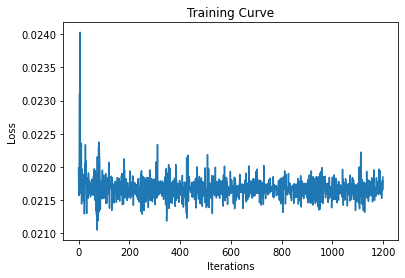

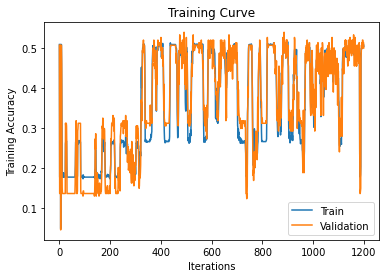

Final Training Accuracy: 0.5041551246537396
Final Validation Accuracy: 0.5


In [21]:
model = SleepNet_ECG()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print("Using CUDA")


train(model, train_dataset, val_dataset, batch_size=64,learning_rate = 0.001, num_epochs=100)
